In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tqdm
import pickle
import matplotlib
import numpy as np
import pandas as pd
import ase.io as aio
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from toolz.curried import pipe, curry, compose

import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install dscribe

     |████████████████████████████████| 92kB 2.3MB/s eta 0:00:011
     |████████████████████████████████| 296kB 6.9MB/s eta 0:00:01
  Created wheel for dscribe: filename=dscribe-0.4.0-cp37-cp37m-linux_x86_64.whl size=2294618 sha256=89e140eb9a79c1ca8ae703f3f292acfc515c510bacb13bf300423c5ef120008a
  Stored in directory: /storage/home/hhive1/ashanker9/.cache/pip/wheels/74/8f/09/b6423fd19da3d85fd72e2ccf133fc71c6251fb9068181bf9b5
Successfully built dscribe


In [3]:
from dscribe.descriptors import SOAP

ModuleNotFoundError: No module named 'dscribe'

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

[DScribe Library Documentation](https://singroup.github.io/dscribe/tutorials/soap.html)

In [4]:
from utils import *

loader = load_dump_file(fmt='lammps-dump-text', 
                        pbc=[1, 1, 1], 
                        sym=['Nb'],)


tagger = get_tagged_atoms(rmsd=0.1, cutoff=10.0)

### When computing for damaged structures, atoms corresponding to the damaged region are considered.

In [16]:
pka = 20000
run = 0
fname_ref = "../data/init-runs/Initial_CuNb_1runonly/Nb_ref/dump.ref.{}_0".format(pka)
fname_irr = "xyz_10_nb/nb_pka_{}_run_{}.xyz".format(pka, run)

In [17]:
atoms_ref = tagger(loader(fname_ref))
atoms_irr = aio.read(fname_irr)

In [18]:
%%time
r_stat = 18
soap = SOAP(species=["Nb"], rcut=r_stat, nmax=9, lmax=9, crossover=True, average=False)

CPU times: user 4.01 ms, sys: 849 µs, total: 4.86 ms
Wall time: 4.09 ms


(500, 450)


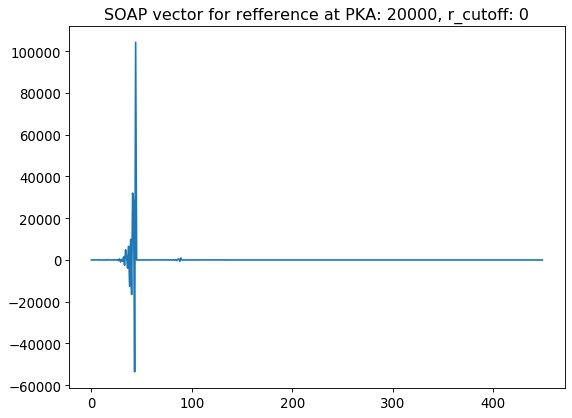

CPU times: user 7.22 s, sys: 5.66 s, total: 12.9 s
Wall time: 16.3 s


In [19]:
%%time
indxs0 = np.random.randint(0, len(atoms_ref), 500)
f_ref = soap.create(atoms_ref, positions=indxs0)
print(f_ref.shape)

plt.plot(np.mean(f_ref, axis=0))
plt.title("SOAP vector for refference at PKA: {}, r_cutoff: {}".format(pka, r_stat))
plt.show()

(687, 450)


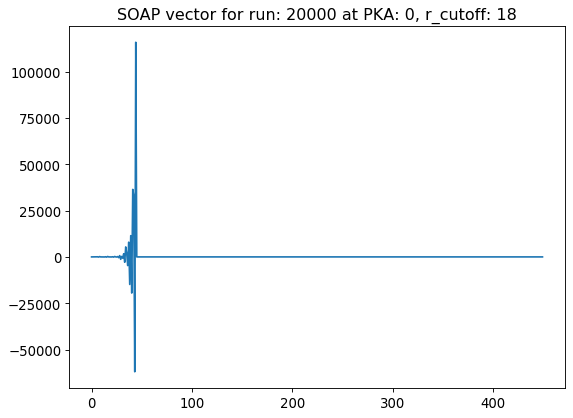

CPU times: user 9.67 s, sys: 6.52 s, total: 16.2 s
Wall time: 23.6 s


In [20]:
%%time
indxs1 = np.where(atoms_irr.get_tags() != 3)[0]
f_irr = soap.create(atoms_irr, positions=indxs1)
print(f_irr.shape)

plt.plot(np.mean(f_irr, axis=0))
plt.title("SOAP vector for run: {} at PKA: {}, r_cutoff: {}".format(pka, run, r_stat))
plt.show()

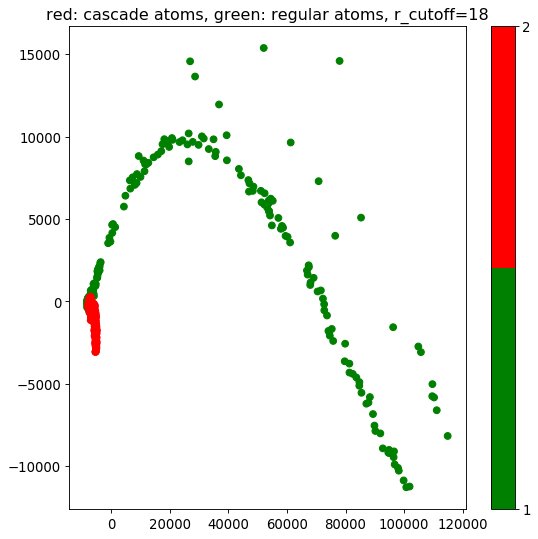

In [21]:
X_data = np.concatenate([f_ref, f_irr], axis=0)
X_emb = PCA(n_components=2).fit_transform(X_data)
# X_emb = TSNE(n_components=2).fit_transform(X_data)



labels = np.concatenate([[1]*len(indxs0), [2]*len(indxs1)])
colors = ['green','red']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=labels, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(1,3, max(labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(np.unique(labels))
plt.title("red: cascade atoms, green: regular atoms, r_cutoff={}".format(r_stat))
plt.show()

In [100]:
pka_list = [500, 1000, 2000, 5000, 10000, 20000]
nrun = 25
runs = np.arange(nrun)

In [1]:
features = []
vols = []
n_atoms_all = []
n_atoms_irr = []

for pka in pka_list:
    for run in tqdm.tqdm_notebook(runs):
        
        atoms = aio.read("xyz_05/cu_pka_{}_run_{}.xyz".format(pka, run))
        atoms.set_chemical_symbols(["Cu"]*len(atoms))
        indxs = np.where(atoms.get_tags() != 1)[0]
        
        vols.append(atoms.get_volume())
        n_atoms_all.append(len(atoms))
        n_atoms_irr.append(len(indxs))
        
        if len(indxs) != 0:
            soap = SOAP(species=["Cu"], rcut=50, nmax=8, lmax=6, crossover=True, average=True)
            feat = soap.create(atoms, positions=indxs)
            features.append(feat)
        else:
            continue

In [107]:
n_atoms_all = n_atoms_all[:125]
n_atoms_irr = n_atoms_irr[:125]
vols = vols[:125]
features = features[:125]

In [108]:
pka_list = [500, 1000, 2000, 5000, 10000,]
nrun = 25
runs = np.arange(nrun)

In [109]:
indxs = np.where(np.asarray(n_atoms_irr)!=0)[0]
print(len(indxs))

120


In [110]:
pka_values = np.ravel([[item/1000]*nrun for item in pka_list])[indxs]

In [111]:
x_data = np.concatenate(features)
print(x_data.shape)

pca = PCA(n_components=10)
scores = pca.fit_transform(x_data)
print(pca.explained_variance_ratio_)

(125, 252)
[9.8191786e-01 1.6743287e-02 9.7557489e-04 2.0371271e-04 8.5396008e-05
 4.4479544e-05 1.4200217e-05 8.3677614e-06 3.3759643e-06 1.4214073e-06]


In [112]:
bins = np.arange(252)

## Correlation Analysis

In [113]:
corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores[:,ix], np.asarray(n_atoms_irr)[indxs])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of PC scores with no. of atoms")
plt.show()


corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores[:,ix], pka_values)[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of PC scores with PKA")
plt.show()

corrs = []
for ix in range(x_data.shape[1]):
    corrs.append(np.fabs(np.corrcoef(scores[:,0], x_data[:,ix])[0,1]))
    
plt.bar(bins, corrs)
plt.title("Correlation of PC 1 with terms in the RDF")
plt.show()

corrs = []
for ix in range(x_data.shape[1]):
    corrs.append(np.fabs(np.corrcoef(np.asarray(n_atoms_irr)[indxs], x_data[:,ix])[0,1]))
    
plt.bar(bins, corrs)
plt.title("Correlation of Cascade Size with terms in the RDF")
plt.show()

corrs = []
for ix in range(x_data.shape[1]):
    corrs.append(np.fabs(np.corrcoef(pka_values, x_data[:,ix])[0,1]))
    
plt.bar(bins, corrs)
plt.title("Correlation of PKA values with terms in the RDF")
plt.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 125 and the array at index 1 has size 120

In [18]:
arr = np.concatenate([scores, pka_values[...,None], 
                      np.asarray(n_atoms_irr)[indxs][...,None], 
                      (np.asarray(n_atoms_irr)/np.asarray(n_atoms_all))[indxs][...,None]], 
                     axis=1)
df = pd.DataFrame(arr, columns=[str(item) for item in range(arr.shape[1])])

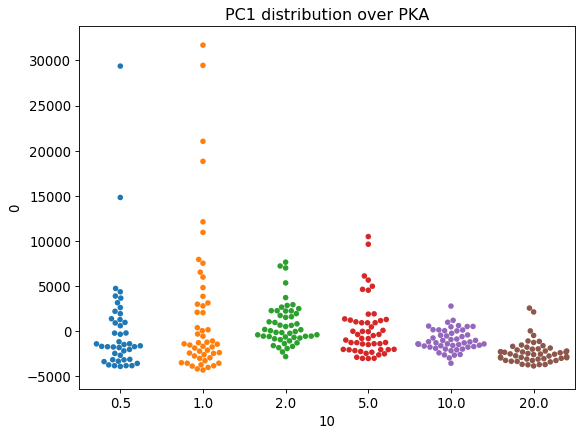

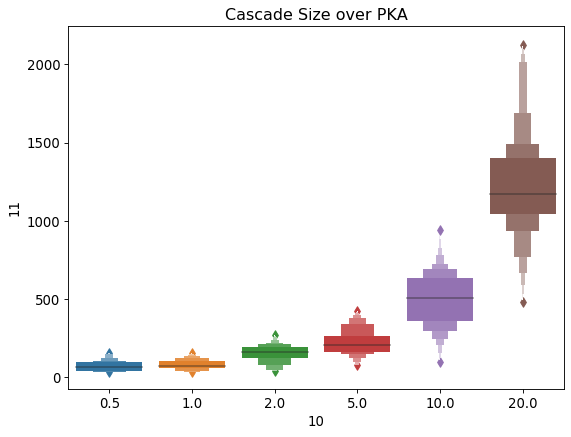

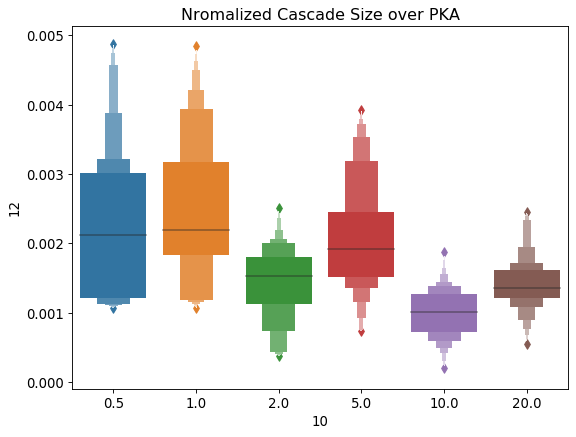

In [19]:
ax = sns.swarmplot(x='10', y='0', data=df)
plt.title("PC1 distribution over PKA")
plt.show()

ax = sns.boxenplot(x='10', y='11', data=df)
plt.title("Cascade Size over PKA")
plt.show()

ax = sns.boxenplot(x='10', y='12', data=df)
plt.title("Nromalized Cascade Size over PKA")
plt.show()

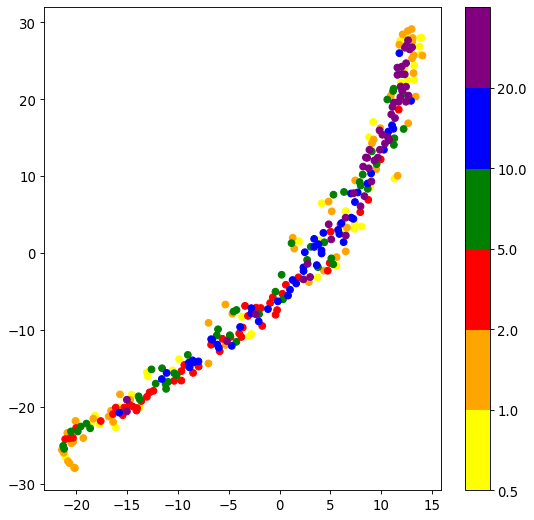

CPU times: user 12.1 s, sys: 360 ms, total: 12.4 s
Wall time: 887 ms


In [20]:
%%time
X_emb = TSNE(n_components=2).fit_transform(x_data)


label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['yellow', 'orange', 'red','green','blue','purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.show()